In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==2.2.0
!pip install tensorflow-addons==0.9.1
!pip install optuna

Found existing installation: tensorflow 2.8.0
Uninstalling tensorflow-2.8.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.8.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.8.0
     |████████████████████████████████| 516.2 MB 3.7 kB/s 
     |████████████████████████████████| 3.0 MB 37.2 MB/s 
     |████████████████████████████████| 2.9 MB 34.1 MB/s 
     |████████████████████████████████| 454 kB 54.9 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.

In [ ]:
import tensorflow as tf ;tf.compat.v1.disable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import optuna
import gc
from tensorflow import keras
from tensorflow.keras import callbacks

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [ ]:
data_online_sess1 = np.load(f"/content/drive/MyDrive/Brainwave_hack/data/phob_data/100Hz_data_online_sess1.npy")
data_online_sess2 = np.load(f"/content/drive/MyDrive/Brainwave_hack/data/phob_data/100Hz_data_online_sess2.npy")
data_offline_sess1 = np.load(f"/content/drive/MyDrive/Brainwave_hack/data/phob_data/100Hz_data_sess1.npy")
data_offline_sess2 = np.load(f"/content/drive/MyDrive/Brainwave_hack/data/phob_data/100Hz_data_sess2.npy")

In [ ]:
label_online_sess1 = np.load(f"/content/drive/MyDrive/Brainwave_hack/data/phob_data/100Hz_label_online_sess1.npy")
label_online_sess2 = np.load(f"/content/drive/MyDrive/Brainwave_hack/data/phob_data/100Hz_label_online_sess2.npy")
label_offline_sess1 = np.load(f"/content/drive/MyDrive/Brainwave_hack/data/phob_data/100Hz_label_sess1.npy")
label_offline_sess2 = np.load(f"/content/drive/MyDrive/Brainwave_hack/data/phob_data/100Hz_label_sess2.npy")

In [ ]:
# concat data
session_x_merge =  np.concatenate((data_online_sess1, data_online_sess2 , data_offline_sess1 , data_offline_sess2) , axis = 0)
session_y_merge = np.concatenate((label_online_sess1, label_online_sess2 , label_offline_sess1 , label_offline_sess2) , axis = 0)
del(data_online_sess1)
del(data_online_sess2)
del(data_offline_sess1) 
del(data_offline_sess2) 

In [ ]:
session_x_merge = np.transpose(session_x_merge , [0,2,1])
session_x_merge = np.expand_dims(session_x_merge, axis = 1)

In [ ]:
print(session_x_merge.shape)

(62400, 1, 62, 400)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(session_x_merge, session_y_merge, test_size=0.2, random_state=44)
print("Number of posters for training: ", len(X_train))
print("Number of posters for validation: ", len(X_val))

Number of posters for training:  49920
Number of posters for validation:  12480


In [ ]:
del(session_x_merge)

# Altenative Bandpass data


In [ ]:
session_x_merge =  np.expand_dims(np.concatenate((np.load(f"/content/drive/MyDrive/Brain Powerrrrrrrr/offline_data_no_bandpass.npy"), np.load(f"/content/drive/MyDrive/Brain Powerrrrrrrr/online_data_no_bandpass.npy")) , axis = 0),axis = 1)
session_y_merge = np.concatenate((np.load(f"/content/drive/MyDrive/Brain Powerrrrrrrr/offline_label_no_bandpass.npy"), np.load(f"/content/drive/MyDrive/Brain Powerrrrrrrr/online_label_no_bandpass.npy")) , axis = 0)

In [ ]:
print(session_x_merge.shape)
print(session_y_merge.shape)

(41600, 1, 62, 400)
(41600,)


In [ ]:
# #Select channel that have C
# session_x_merge=session_x_merge[:,:,[7, 8, 9, 10, 12, 13, 14, 17, 18, 19, 20, 32, 33, 34, 35, 36, 37, 38, 39, 40],:]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(session_x_merge, session_y_merge, test_size=0.2, random_state=44)
print("Number of posters for training: ", len(X_train))
print("Number of posters for validation: ", len(X_val))

Number of posters for training:  33280
Number of posters for validation:  8320


In [ ]:
del(session_x_merge)
gc.collect()

111

# Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import numpy as np
import os
import time
from sklearn.metrics import classification_report, f1_score

In [ ]:
class DeepConvNet:
    def __init__(self,
                input_shape=(1,20,400),
                num_class=2,
                loss='sparse_categorical_crossentropy',
                epochs=200,
                batch_size=100,
                optimizer = Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08),
                lr=0.01,
                min_lr=0.01,
                factor=0.25,
                patience=10,
                es_patience=20,
                verbose=1,
                log_path='logs',
                model_name='DeepConvNet',
                **kwargs):
        self.input_shape = input_shape
        self.num_class = num_class
        self.loss = loss
        self.epochs = epochs
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.optimizer.lr = lr
        self.lr = lr
        self.min_lr = min_lr
        self.factor = factor
        self.patience = patience
        self.es_patience = es_patience
        self.verbose = verbose
        self.log_path = log_path
        self.model_name = model_name
        self.weights_dir = log_path+'/'+model_name+'_out_weights.h5'
        self.csv_dir = log_path+'/'+model_name+'_out_log.log'
        self.time_log = log_path+'/'+model_name+'_time_log.csv'

        # use **kwargs to set the new value of below args.
        self.kernLength = 125
        self.norm_rate = 0.25
        self.dropout_rate = 0.5
        self.data_format = 'channels_first'
        self.shuffle = False
        self.metrics = 'accuracy'
        self.monitor = 'val_loss'
        self.mode = 'min'
        self.save_best_only = True
        self.save_weight_only = True
        self.seed = 1234
        self.class_balancing = False
        self.class_weight = None

        for k in kwargs.keys():
            self.__setattr__(k, kwargs[k])
            
        if self.data_format == 'channels_first':
            self.Chans = self.input_shape[1]
            self.Samples = self.input_shape[2]
        else:
            self.Chans = self.input_shape[0]
            self.Samples = self.input_shape[1]

        np.random.seed(self.seed)
        tf.random.set_seed(self.seed)
        K.set_image_data_format(self.data_format)
        if not os.path.exists(self.log_path):
            os.makedirs(self.log_path)

    def build(self):
        """ Keras implementation of the Deep Convolutional Network as described in
        Schirrmeister et. al. (2017), Human Brain Mapping.
        This implementation assumes the input is a 2-second EEG signal sampled at
        128Hz, as opposed to signals sampled at 250Hz as described in the original
        paper. We also perform temporal convolutions of length (1, 5) as opposed
        to (1, 10) due to this sampling rate difference.
        Note that we use the max_norm constraint on all convolutional layers, as
        well as the classification layer. We also change the defaults for the
        BatchNormalization layer. We used this based on a personal communication
        with the original authors.
                          ours        original paper
        pool_size        1, 2        1, 3
        strides          1, 2        1, 3
        conv filters     1, 5        1, 10
        Note that this implementation has not been verified by the original
        authors.
        """

        # start the model
        input_main   = Input(self.input_shape)
        block1       = Conv2D(25, (1, 5),
                              input_shape=(self.input_shape),
                              kernel_constraint=max_norm(2., axis=(0, 1, 2)))(input_main)
        block1       = Conv2D(25, (self.Chans, 1),
                              kernel_constraint=max_norm(2., axis=(0, 1, 2)))(block1)
        block1       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block1)
        block1       = Activation('elu')(block1)
        block1       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block1)
        block1       = Dropout(self.dropout_rate)(block1)

        block2       = Conv2D(50, (1, 5),
                              kernel_constraint=max_norm(2., axis=(0, 1, 2)))(block1)
        block2       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block2)
        block2       = Activation('elu')(block2)
        block2       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block2)
        block2       = Dropout(self.dropout_rate)(block2)

        block3       = Conv2D(100, (1, 5),
                              kernel_constraint=max_norm(2., axis=(0, 1, 2)))(block2)
        block3       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block3)
        block3       = Activation('elu')(block3)
        block3       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block3)
        block3       = Dropout(self.dropout_rate)(block3)

        block4       = Conv2D(200, (1, 5),
                              kernel_constraint=max_norm(2., axis=(0, 1, 2)))(block3)
        block4       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block4)
        block4       = Activation('elu')(block4)
        block4       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block4)
        block4       = Dropout(self.dropout_rate)(block4)

        flatten      = Flatten()(block4)

        dense        = Dense(self.num_class, kernel_constraint = max_norm(0.5))(flatten)
        softmax      = Activation('softmax')(dense)

        return Model(inputs=input_main, outputs=softmax)

    def fit(self, X_train, y_train, X_val, y_val):

        if X_train.ndim != 4:
            raise Exception('ValueError: `X_train` is incompatible: expected ndim=4, found ndim='+str(X_train.ndim))
        elif X_val.ndim != 4:
            raise Exception('ValueError: `X_val` is incompatible: expected ndim=4, found ndim='+str(X_val.ndim))

        self.input_shape = X_train.shape[1:]
        if self.data_format == 'channels_first':
            self.Chans = self.input_shape[1]
            self.Samples = self.input_shape[2]
        else:
            self.Chans = self.input_shape[0]
            self.Samples = self.input_shape[1]
        
        csv_logger = CSVLogger(self.csv_dir)
        checkpointer = ModelCheckpoint(monitor=self.monitor, filepath=self.weights_dir, verbose=self.verbose, 
                                       save_best_only=self.save_best_only, save_weight_only=self.save_weight_only)
        reduce_lr = ReduceLROnPlateau(monitor=self.monitor, patience=self.patience, factor=self.factor, mode=self.mode, 
                                      verbose=self.verbose, min_lr=self.min_lr)
        es = EarlyStopping(monitor=self.monitor, mode=self.mode, verbose=self.verbose, patience=self.es_patience)

        model = self.build()
        model.compile(optimizer=self.optimizer, loss=self.loss, metrics=[self.metrics])
        model.summary()
        
            
        model.fit(X_train, y_train,
                  batch_size=self.batch_size, shuffle=self.shuffle,
                  epochs=self.epochs, validation_data=(X_val, y_val), class_weight=self.class_weight,
                  callbacks=[checkpointer,csv_logger,reduce_lr,es])
    def fit_continue(self, X_train, y_train, X_val, y_val):

        if X_train.ndim != 4:
            raise Exception('ValueError: `X_train` is incompatible: expected ndim=4, found ndim='+str(X_train.ndim))
        elif X_val.ndim != 4:
            raise Exception('ValueError: `X_val` is incompatible: expected ndim=4, found ndim='+str(X_val.ndim))

        self.input_shape = X_train.shape[1:]
        if self.data_format == 'channels_first':
            self.Chans = self.input_shape[1]
            self.Samples = self.input_shape[2]
        else:
            self.Chans = self.input_shape[0]
            self.Samples = self.input_shape[1]
        
        csv_logger = CSVLogger(self.csv_dir)
        checkpointer = ModelCheckpoint(monitor=self.monitor, filepath=self.weights_dir, verbose=self.verbose, 
                                       save_best_only=self.save_best_only, save_weight_only=self.save_weight_only)
        reduce_lr = ReduceLROnPlateau(monitor=self.monitor, patience=self.patience, factor=self.factor, mode=self.mode, 
                                      verbose=self.verbose, min_lr=self.min_lr)
        es = EarlyStopping(monitor=self.monitor, mode=self.mode, verbose=self.verbose, patience=self.es_patience)

        model = self.build()
        model.load_weights(self.weights_dir)
        model.compile(optimizer=self.optimizer, loss=self.loss, metrics=[self.metrics])
        model.summary()
        
            
        model.fit(X_train, y_train,
                  batch_size=self.batch_size, shuffle=self.shuffle,
                  epochs=self.epochs, validation_data=(X_val, y_val), class_weight=self.class_weight,
                  callbacks=[checkpointer,csv_logger,reduce_lr,es])

    def predict(self, X_test):

        if X_test.ndim != 4:
            raise Exception('ValueError: `X_test` is incompatible: expected ndim=4, found ndim='+str(X_test.ndim))

        model = self.build()
        model.load_weights(self.weights_dir)
        model.compile(optimizer=self.optimizer, loss=self.loss, metrics=[self.metrics])
        model.summary()

        y_pred = model.predict(X_test)
        y_pred_argm = np.argmax(y_pred, axis=1)
        return y_pred_argm 

In [ ]:
def objective(trial):
  dropout_rate=trial.suggest_float('dropout_rate', 0.1, 0.5, log=True)
  batch_size=trial.suggest_int('batch_size', 128, 1024, log=True)

  model=DeepConvNet(input_shape=(1,62,400), num_class=4, dropout_rate=dropout_rate, shuffle=True).build()

  checkpointer = ModelCheckpoint(monitor='val_accuracy', filepath='/content/drive/MyDrive/Brain Powerrrrrrrr/Save_weight/DeepConvNetOptuna.h5', verbose=1, 
                                       save_best_only=True, save_weight_only=True)
  reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=10, factor=0.25, mode='max', 
                                      verbose=1, min_lr=1e-5)
  es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

  model.compile(optimizer=Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08,learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  # model.fit_generator(generator=training_generator,
  #                   validation_data=validation_generator,
  #                   workers=6,epochs=400,callbacks=[checkpointer,reduce_lr,es])
  model.fit(X_train,y_train,validation_data=(X_val, y_val),shuffle=True,batch_size=batch_size,epochs=400,callbacks=[checkpointer,reduce_lr,es])

  score = model.evaluate(X_val, y_val, verbose=0)

  return score[1]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [ ]:
model = DeepConvNet(input_shape=(1,62,400), num_class=4, dropout_rate=0.25, shuffle=True , batch_size= 1024 , lr=0.001,epochs=400,min_lr=1e-5)

In [ ]:
model.fit(X_train, y_train, X_val, y_val)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 62, 400)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 25, 62, 396)       150       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 1, 396)        38775     
_________________________________________________________________
batch_normalization (BatchNo (None, 25, 1, 396)        100       
_________________________________________________________________
activation (Activation)      (None, 25, 1, 396)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 1, 198)        0         
______________________________________________

In [ ]:
model = DeepConvNet(input_shape=(1,62,400), num_class=4, batch_size = 1024 ,log_path='/content/drive/MyDrive/Brainwave_hack/model/bandpass' , lr=0.001)

In [ ]:
model.fit_continue(X_train, y_train, X_val, y_val)

# Prediction Band pass


In [ ]:
x_test_public = np.load(f"/content/drive/MyDrive/Brain Powerrrrrrrr/test_data_no_bandpass.npy")
x_test_private = np.load(f"/content/drive/MyDrive/Brain Powerrrrrrrr/final_test_data_no_bandpass.npy")

In [ ]:
print(x_test_public.shape)
print(x_test_private.shape)

(400, 62, 400)
(400, 62, 400)


In [ ]:
x_test =  np.concatenate((x_test_public, x_test_private) , axis = 0)

In [ ]:
x_test = np.expand_dims(x_test, axis = 1)

In [ ]:
x_test.shape

(800, 1, 62, 400)

In [ ]:
model = DeepConvNet(input_shape=(1,62,400), num_class=4, batch_size = 1024 ,log_path='/content/logs')

In [ ]:
pred = model.predict(x_test)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1, 62, 400)]      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 25, 62, 396)       150       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 25, 1, 396)        38775     
_________________________________________________________________
batch_normalization_8 (Batch (None, 25, 1, 396)        100       
_________________________________________________________________
activation_10 (Activation)   (None, 25, 1, 396)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 25, 1, 198)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 25, 1, 198)        0   

In [ ]:
pred

array([0, 2, 2, 1, 0, 2, 0, 3, 1, 1, 0, 3, 1, 0, 0, 3, 3, 1, 3, 0, 0, 0,
       0, 1, 1, 1, 2, 3, 0, 2, 2, 0, 1, 0, 1, 0, 1, 3, 1, 0, 3, 0, 0, 2,
       2, 1, 1, 3, 1, 2, 3, 3, 1, 1, 3, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1, 1,
       3, 1, 0, 1, 3, 2, 2, 1, 2, 0, 3, 2, 0, 0, 2, 2, 1, 1, 1, 1, 1, 0,
       3, 3, 2, 1, 0, 3, 3, 2, 3, 3, 3, 1, 3, 3, 0, 1, 2, 3, 2, 1, 1, 3,
       0, 2, 2, 2, 0, 2, 3, 1, 3, 2, 3, 2, 0, 2, 2, 3, 3, 0, 2, 2, 0, 3,
       1, 2, 2, 2, 2, 0, 2, 1, 0, 1, 3, 2, 2, 1, 0, 2, 3, 0, 0, 1, 3, 1,
       0, 1, 3, 0, 0, 1, 3, 2, 3, 3, 3, 3, 3, 0, 3, 1, 3, 0, 2, 2, 3, 2,
       3, 0, 2, 0, 2, 0, 2, 3, 2, 3, 1, 0, 3, 2, 1, 2, 2, 2, 1, 1, 1, 0,
       0, 1, 2, 2, 3, 1, 1, 2, 3, 1, 2, 3, 1, 2, 2, 2, 2, 3, 1, 2, 3, 2,
       1, 2, 0, 2, 2, 0, 2, 0, 3, 2, 1, 3, 3, 3, 2, 3, 3, 3, 1, 1, 2, 3,
       2, 2, 2, 2, 2, 0, 0, 2, 0, 3, 1, 3, 0, 1, 3, 1, 2, 2, 1, 1, 2, 1,
       2, 1, 0, 3, 1, 3, 0, 2, 3, 3, 0, 1, 0, 1, 1, 2, 1, 0, 1, 0, 1, 2,
       0, 1, 1, 1, 2, 3, 1, 3, 0, 0, 1, 0, 2, 3, 0,

In [ ]:
pred

array([1, 2, 0, 1, 0, 2, 1, 3, 3, 1, 0, 1, 1, 0, 0, 1, 3, 1, 3, 2, 0, 0,
       2, 1, 2, 1, 3, 3, 0, 2, 2, 0, 1, 0, 1, 0, 1, 2, 1, 0, 3, 0, 0, 3,
       2, 1, 1, 3, 1, 2, 3, 2, 1, 1, 3, 1, 0, 0, 0, 0, 2, 0, 1, 0, 1, 1,
       3, 1, 0, 1, 3, 1, 2, 1, 3, 0, 1, 2, 0, 0, 3, 2, 1, 1, 1, 1, 0, 0,
       3, 3, 3, 1, 1, 3, 3, 0, 3, 3, 2, 3, 3, 2, 0, 3, 2, 2, 2, 1, 1, 1,
       0, 2, 2, 2, 0, 2, 3, 1, 3, 2, 3, 0, 0, 2, 2, 3, 3, 0, 2, 2, 0, 1,
       0, 3, 2, 2, 2, 0, 2, 1, 0, 1, 3, 2, 0, 3, 0, 2, 3, 1, 1, 1, 3, 1,
       1, 1, 2, 0, 0, 1, 3, 2, 1, 3, 3, 2, 3, 2, 3, 1, 3, 0, 0, 3, 3, 2,
       3, 2, 2, 0, 2, 0, 2, 3, 3, 3, 1, 0, 3, 2, 2, 2, 2, 2, 1, 1, 1, 0,
       0, 1, 2, 2, 3, 1, 2, 3, 3, 1, 2, 3, 1, 2, 2, 2, 2, 3, 1, 2, 3, 2,
       1, 2, 2, 2, 2, 0, 2, 0, 3, 2, 1, 3, 3, 3, 2, 3, 2, 3, 0, 3, 2, 3,
       3, 0, 2, 3, 2, 0, 1, 2, 0, 3, 1, 2, 0, 1, 3, 1, 2, 2, 1, 1, 2, 2,
       2, 1, 0, 3, 1, 3, 0, 3, 2, 3, 0, 1, 3, 1, 1, 0, 1, 0, 1, 2, 2, 2,
       0, 1, 1, 1, 2, 3, 1, 3, 0, 1, 1, 0, 3, 3, 0,

In [ ]:
import pandas as pd
submission = pd.read_csv('/content/sample_submission (1).csv')

In [ ]:
submission['prediction'][:] = pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
submission = submission.fillna(0)

In [ ]:
submission['prediction'] = submission['prediction'].astype(int)

In [ ]:
submission

,sample_id,prediction
0,1,0
1,2,2
2,3,2
3,4,1
4,5,0
...,...,...
795,f396,0
796,f397,3
797,f398,2
798,f399,1


In [ ]:
submission

,sample_id,prediction
0,1,0
1,2,2
2,3,2
3,4,1
4,5,0
...,...,...
795,f396,0
796,f397,3
797,f398,2
798,f399,1


In [ ]:
submission.to_csv('/content/not_working.csv', index=False)

# Prediction normal

In [ ]:
x_test = np.load(f"/content/drive/MyDrive/Brainwave_hack/data/100_final_test.npy")

In [ ]:
x_test = np.expand_dims(x_test, axis = 1)

In [ ]:
x_test.shape

(800, 1, 62, 400)

In [ ]:
model = DeepConvNet(input_shape=(1,62,400), num_class=4, batch_size = 1024 ,log_path='/content/drive/MyDrive/Brainwave_hack/model/holyshit20val')

In [ ]:
pred = model.predict(x_test)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 62, 400)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 25, 62, 396)       150       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 1, 396)        38775     
_________________________________________________________________
batch_normalization (BatchNo (None, 25, 1, 396)        100       
_________________________________________________________________
activation (Activation)      (None, 25, 1, 396)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 1, 198)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 1, 198)        0     

In [ ]:
pred

array([0, 2, 3, 1, 0, 2, 0, 3, 1, 1, 0, 3, 1, 0, 0, 3, 3, 1, 3, 0, 0, 0,
       1, 1, 1, 1, 3, 3, 0, 2, 2, 0, 1, 0, 1, 0, 1, 3, 1, 0, 3, 1, 0, 3,
       2, 1, 1, 3, 1, 2, 3, 3, 1, 1, 3, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 1,
       3, 1, 0, 1, 3, 1, 2, 1, 2, 0, 3, 2, 0, 0, 3, 2, 1, 1, 1, 1, 1, 0,
       3, 3, 3, 1, 0, 3, 3, 2, 3, 3, 3, 3, 3, 3, 0, 1, 2, 3, 2, 1, 1, 3,
       0, 2, 2, 3, 0, 2, 3, 0, 3, 2, 3, 3, 0, 2, 2, 3, 3, 0, 3, 2, 0, 1,
       1, 2, 2, 2, 2, 0, 2, 1, 0, 1, 3, 2, 0, 3, 1, 3, 3, 0, 0, 1, 3, 1,
       1, 1, 3, 0, 0, 1, 3, 2, 3, 3, 3, 3, 3, 1, 2, 1, 3, 0, 2, 3, 3, 2,
       3, 0, 2, 0, 2, 0, 2, 3, 3, 3, 1, 0, 3, 2, 2, 2, 2, 2, 1, 1, 1, 0,
       0, 0, 2, 2, 3, 1, 2, 3, 3, 1, 2, 3, 1, 2, 2, 2, 2, 3, 1, 2, 3, 3,
       1, 2, 0, 2, 3, 0, 3, 0, 3, 3, 1, 3, 3, 3, 2, 3, 3, 3, 1, 0, 2, 3,
       3, 2, 2, 2, 2, 0, 1, 2, 0, 3, 1, 2, 0, 1, 3, 1, 2, 2, 1, 1, 2, 1,
       2, 1, 0, 3, 1, 3, 0, 1, 2, 3, 0, 1, 0, 1, 1, 2, 3, 0, 1, 0, 0, 2,
       0, 1, 1, 1, 2, 3, 1, 3, 0, 1, 2, 1, 2, 3, 1,

In [ ]:
import pandas as pd
submission = pd.read_csv('/content/sample_submission.csv')

In [ ]:
submission['prediction'][:] = pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
submission['prediction'] = submission['prediction'].astype(int)

In [ ]:
submission

,sample_id,prediction
0,1,0
1,2,2
2,3,3
3,4,1
4,5,0
...,...,...
795,f396,0
796,f397,3
797,f398,2
798,f399,1


In [ ]:
submission.to_csv('/content/maximum_power.csv', index=False)

# MIN2NET

In [ ]:
!pip install min2net

In [ ]:
!pip install numpy==1.19.5

In [ ]:
from tensorflow.keras.layers import Concatenate, AveragePooling2D, BatchNormalization, Conv2D, Conv2DTranspose, Dense, Input, Reshape, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import backend as K

import numpy as np
import os
import time
from sklearn.metrics import classification_report, f1_score
from min2net.loss import mean_squared_error, triplet_loss, SparseCategoricalCrossentropy
from min2net.utils import TimeHistory, compute_class_weight

class MIN2Net:
    def __init__(self,
                input_shape=(1,400,20), 
                num_class=2, 
                loss=[triplet_loss(margin=1.0), 'sparse_categorical_crossentropy'],
                loss_weights=[1., 1.], 
                latent_dim = None,
                epochs=200,
                batch_size=100,
                optimizer=Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08),
                lr=1e-2,
                min_lr=1e-3,
                factor=0.5,
                patience=5, 
                es_patience=20,
                verbose=1,
                log_path='logs',
                model_name='MIN2Net', 
                **kwargs):
        D, T, C = input_shape
        self.latent_dim = latent_dim if latent_dim is not None else C if num_class==2 else 64
        self.num_class = num_class
        self.input_shape = input_shape
        self.loss = loss
        self.loss_weights = loss_weights
        self.epochs = epochs
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.optimizer.lr = lr
        self.lr = lr
        self.min_lr = min_lr
        self.factor = factor
        self.patience = patience
        self.es_patience = es_patience
        self.verbose = verbose
        self.log_path = log_path
        self.model_name = model_name
        self.weights_dir = log_path+'/'+model_name+'_out_weights.h5'
        self.csv_dir = log_path+'/'+model_name+'_out_log.log'
        self.time_log = log_path+'/'+model_name+'_time_log.csv'

        # use **kwargs to set the new value of below args.
        self.f1_average = 'binary' if self.num_class == 2 else 'macro'
        self.data_format = 'channels_last'
        self.shuffle = False
        self.metrics = 'accuracy'
        self.monitor = 'val_loss'
        self.mode = 'min'
        self.save_best_only = True
        self.save_weight_only = True
        self.seed = 1234
        self.class_balancing = False
        # 'set params'
        self.subsampling_size = 100
        self.pool_size_1 = (1,T//self.subsampling_size)
        self.pool_size_2 = (1,4)
        self.filter_1 = C
        self.filter_2 = 10
        
        for k in kwargs.keys():
            self.__setattr__(k, kwargs[k])
        
        self.flatten_size = T//self.pool_size_1[1]//self.pool_size_2[1]
        
        np.random.seed(self.seed)
        tf.random.set_seed(self.seed)
        K.set_image_data_format(self.data_format)
        if not os.path.exists(self.log_path):
            os.makedirs(self.log_path)

    def build(self):
        'encoder'
        encoder_input  = Input(self.input_shape)
        en_conv        = Conv2D(self.filter_1, (1, 64), activation='elu', padding="same", 
                                kernel_constraint=max_norm(2., axis=(0, 1, 2)))(encoder_input)
        en_conv        = BatchNormalization(axis=3, epsilon=1e-05, momentum=0.1)(en_conv)
        en_conv        = AveragePooling2D(pool_size=self.pool_size_1)(en_conv)  
        en_conv        = Conv2D(self.filter_2, (1, 32), activation='elu', padding="same", 
                                kernel_constraint=max_norm(2., axis=(0, 1, 2)))(en_conv)
        en_conv        = BatchNormalization(axis=3, epsilon=1e-05, momentum=0.1)(en_conv)
        en_conv        = AveragePooling2D(pool_size=self.pool_size_2)(en_conv)
        en_conv        = Flatten()(en_conv)
        encoder_output = Dense(self.latent_dim, kernel_constraint=max_norm(0.5))(en_conv)
        encoder        = Model(inputs=encoder_input, outputs=encoder_output, name='encoder')
        encoder.summary()
        
        # 'decoder'
        # decoder_input  = Input(shape=(self.latent_dim,), name='decoder_input')
        # de_conv        = Dense(1*self.flatten_size*self.filter_2, activation='elu', 
        #                        kernel_constraint=max_norm(0.5))(decoder_input)
        # de_conv        = Reshape((1, self.flatten_size, self.filter_2))(de_conv)
        # de_conv        = Conv2DTranspose(filters=self.filter_2, kernel_size=(1, 64), 
        #                                  activation='elu', padding='same', strides=self.pool_size_2, 
        #                                  kernel_constraint=max_norm(2., axis=(0, 1, 2)))(de_conv)
        # decoder_output = Conv2DTranspose(filters=self.filter_1, kernel_size=(1, 32), 
        #                                  activation='elu', padding='same', strides=self.pool_size_1, 
        #                                  kernel_constraint=max_norm(2., axis=(0, 1, 2)))(de_conv)
        # decoder        = Model(inputs=decoder_input, outputs=decoder_output, name='decoder')
        # decoder.summary()

        'Build the computation graph for training'
        latent         = encoder(encoder_input)
        # train_xr       = decoder(latent)
        z              = Dense(self.num_class, activation='softmax', kernel_constraint=max_norm(0.5), 
                               name='classifier')(latent)

        return Model(inputs=encoder_input, outputs=[latent, z], 
                            name='MIN2Net')
    
    def fit(self, X_train, y_train, X_val, y_val):
            
        if X_train.ndim != 4:
            raise Exception('ValueError: `X_train` is incompatible: expected ndim=4, found ndim='+str(X_train.ndim))
        elif X_val.ndim != 4:
            raise Exception('ValueError: `X_val` is incompatible: expected ndim=4, found ndim='+str(X_val.ndim))

        csv_logger    = CSVLogger(self.csv_dir)
        time_callback = TimeHistory(self.time_log)
        checkpointer  = ModelCheckpoint(monitor=self.monitor, filepath=self.weights_dir, 
                                        verbose=self.verbose, save_best_only=self.save_best_only, 
                                        save_weight_only=self.save_weight_only)
        reduce_lr     = ReduceLROnPlateau(monitor=self.monitor, patience=self.patience, 
                                          factor=self.factor, mode=self.mode, verbose=self.verbose, 
                                          min_lr=self.min_lr)
        es            = EarlyStopping(monitor=self.monitor, mode=self.mode, verbose=self.verbose, 
                                      patience=self.es_patience)
        model = self.build()     
        model.summary()
        
        if self.class_balancing: # compute_class_weight if class_balancing is True
            class_weight  = compute_class_weight(y_train)
            self.loss[-1] = SparseCategoricalCrossentropy(class_weight=class_weight)
        
        model.compile(optimizer=self.optimizer, loss=self.loss, metrics=[self.metrics], loss_weights=self.loss_weights)

        model.fit(x=X_train, y=[X_train,y_train,y_train],
                          batch_size=self.batch_size, shuffle=self.shuffle,
                          epochs=self.epochs, validation_data=(X_val, [X_val,y_val,y_val]),
                          callbacks=[checkpointer,csv_logger,reduce_lr,es])
        
    def predict(self, X_test):

        if X_test.ndim != 4:
            raise Exception('ValueError: `X_test` is incompatible: expected ndim=4, found ndim='+str(X_test.ndim))

        model = self.build()
        model.summary()
        model.load_weights(self.weights_dir)
        model.compile(optimizer=self.optimizer, loss=self.loss, metrics=[self.metrics], loss_weights=self.loss_weights)

        start = time.time()
        y_pred_decoder, y_pred_trip, y_pred_clf = model.predict(X_test)
        end = time.time()

        y_pred_argm = np.argmax(y_pred_clf, axis=1)

        return y_pred_argm

In [ ]:
min2net=MIN2Net(input_shape=(1,400,62), 
                num_class=4, 
                loss=[mean_squared_error, triplet_loss(margin=1.0), 'sparse_categorical_crossentropy'],
                loss_weights=[1., 2.], 
                latent_dim = None,
                epochs=400,
                batch_size=1024,
                optimizer=Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08),
                lr=1e-3,
                min_lr=1e-5,
                factor=0.5,
                patience=5, 
                es_patience=20)

In [ ]:
session_x_merge =  np.float32(np.concatenate((np.load(f"/content/drive/MyDrive/Brain Powerrrrrrrr/offline_data_no_bandpass.npy"), np.load(f"/content/drive/MyDrive/Brain Powerrrrrrrr/online_data_no_bandpass.npy")) , axis = 0))
session_y_merge = np.concatenate((np.load(f"/content/drive/MyDrive/Brain Powerrrrrrrr/offline_label_no_bandpass.npy"), np.load(f"/content/drive/MyDrive/Brain Powerrrrrrrr/online_label_no_bandpass.npy")) , axis = 0)

In [ ]:
session_x_merge.shape

(41600, 62, 400)

In [ ]:
np.swapaxes(session_x_merge, 1, 2).shape

(41600, 400, 62)

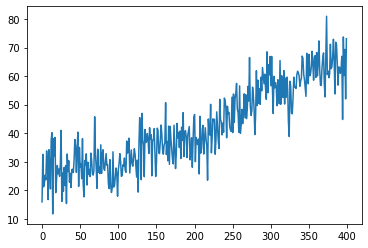

In [ ]:
plt.plot(np.swapaxes(session_x_merge, 1, 2)[0,:,0])

In [ ]:
session_x_merge=np.expand_dims(np.swapaxes(session_x_merge, 1, 2),1)
session_x_merge.shape

(41600, 1, 400, 62)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(session_x_merge, session_y_merge, test_size=0.2, random_state=44)
print("Number of posters for training: ", len(X_train))
print("Number of posters for validation: ", len(X_val))

Number of posters for training:  33280
Number of posters for validation:  8320


In [ ]:
del session_x_merge
gc.collect()

161

In [ ]:
min2net.fit(X_train,y_train,X_val,y_val)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 400, 62)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 400, 62)        246078    
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 400, 62)        248       
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 100, 62)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 100, 10)        19850     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 100, 10)        40        
____________________________________________

ResourceExhaustedError: ignored